In [85]:
import torch 
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import optim
from torch import nn
import os

In [86]:
from glob import glob
import os
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from torch import optim
from torchvision import models
from torch import nn
import torch
from torch.optim import lr_scheduler
import time
import copy
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import normalized_mutual_info_score
from PIL import Image
import seaborn as sns

In [87]:
import torchvision
import torch
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import IncrementalPCA
import numpy as np
from torch.optim import lr_scheduler
import time
from sklearn.preprocessing import StandardScaler

In [88]:
from glob import glob
import pandas as pd

In [89]:
%cd /content/drive/MyDrive/MLDM project

/content/drive/MyDrive/MLDM project


In [90]:
path = '/content/drive/MyDrive/MLDM project/10 imgs.rar (Unzipped Files)/10 imgs/'

In [91]:
batch_size_test = 128
batch_size_train = 128

In [92]:
classes = os.listdir(path)[1:]

In [93]:
classes

['apple_pie',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'meta']

In [94]:
data = pd.DataFrame({})
imgs = []
labels = []
for i in classes:
  for j in glob(f'{path}{i}/*.jpg'):
    imgs.append(j)
    labels.append(i)
data['images'] = imgs
data['labels'] = labels

In [95]:
data = data.sample(frac=1).reset_index(drop=True)

In [96]:
data.head()

,images,labels
0,/content/drive/MyDrive/MLDM project/10 imgs.ra...,bread_pudding
1,/content/drive/MyDrive/MLDM project/10 imgs.ra...,beignets
2,/content/drive/MyDrive/MLDM project/10 imgs.ra...,apple_pie
3,/content/drive/MyDrive/MLDM project/10 imgs.ra...,apple_pie
4,/content/drive/MyDrive/MLDM project/10 imgs.ra...,breakfast_burrito


In [97]:
data.shape

(9000, 2)

In [98]:
from sklearn.model_selection import train_test_split

In [99]:
X_train, X_test, y_train, y_test = train_test_split(data['images'], data['labels'], test_size=0.2, random_state=42)

In [100]:
from sklearn import preprocessing

In [101]:
class Foods(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.my_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((256, 256)),
    ])
    self.encoder = {}
    idx = 0
    for i in np.unique(labels):
      if self.encoder.get(i) == None:
        self.encoder[i] = idx
        idx += 1


  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    # img = Image.open(self.images[idx])
    img = cv2.imread(self.images[idx])
    img = self.my_transforms(img)
    label = self.labels[idx]
    return img, self.encoder[label]


In [102]:
train_loader = torch.utils.data.DataLoader(Foods(X_train.values, y_train.values), batch_size=batch_size_train , shuffle=True)
test_loader = torch.utils.data.DataLoader(Foods(X_test.values, y_test.values), batch_size=batch_size_test , shuffle=True)

In [103]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

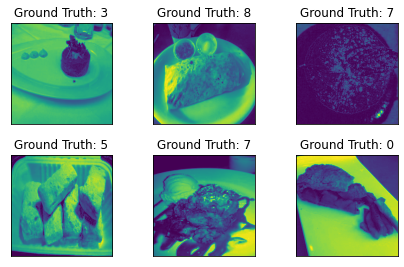

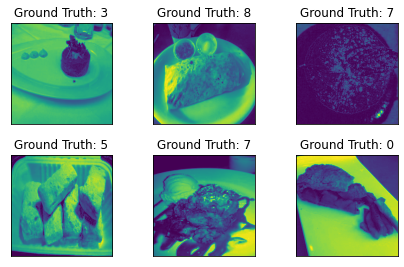

In [104]:
import matplotlib.pyplot as plt

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0])
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
fig

In [105]:
class SSL(nn.Module):
    
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=1, padding=1),
            nn.MaxPool2d(3),
            nn.ReLU(True),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 32, 4, stride=2, padding=1),
            nn.MaxPool2d(3),
            nn.ReLU(True),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 16,2, stride=1, padding=1),
            nn.MaxPool2d(2),
            nn.ReLU(True),
            nn.BatchNorm2d(16),
        )

        self.flatten1 = nn.Flatten(start_dim=1)
        self.fc1 = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(True),
            nn.Linear(128, 100),
            nn.ReLU(True),
            nn.Linear(100, 10),
        )


       

        
    def forward(self, x):
      x = self.conv1(x)
      x = self.flatten1(x)
      out = x
      x = self.fc1(x)
      return x, out

In [106]:
dataloaders = {
    'train':train_loader, 
    'val': test_loader
}
dataset_sizes = {
    'train':X_train.shape[0],
    'val':X_test.shape[0]
}

In [107]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cpu = torch.device('cpu')

In [108]:
kmeans = MiniBatchKMeans(n_clusters=10, batch_size=512, max_iter=1000, init_size=3*100)

In [109]:
device

device(type='cuda', index=0)

In [113]:
def train_model(model, criterion_class, optimizer, num_epochs=25, c=1000):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = 5
    first_time = True
    # флаг для определения первого батча

    flag_cluster = True

    if flag_cluster:
      for epoch in range(num_epochs):
          print('Epoch {}/{}'.format(epoch, num_epochs - 1))
          print('-' * 10)

          # Each epoch has a training and validation phase
          
          for phase in ['train', 'val']:
              if phase == 'train':
                  model.train()  # Set model to training mode
              else:
                  model.eval()   # Set model to evaluate mode

              running_loss = 0.0
              running_corrects = []
              train_acc = []
              val_acc = []
              cluster_acc = []

              batch_num = 0
              # Iterate over data.
              for inputs, class_labels in dataloaders[phase]:

                  inputs = inputs.to(device)
                  class_labels = class_labels.to(device)
                  
                  # zero the parameter gradients
                  optimizer.zero_grad()

                  # forward
                  # track history if only in train

                  with torch.set_grad_enabled(phase == 'train'):
                
                      class_out, vectors = model(inputs)
                      _, preds = torch.max(class_out, 1)
                      vectors = vectors.to(cpu)
                      vectors_np = vectors.detach().numpy()
                      # vectors_np = pca.fit_transform(vectors_np)
                      print(vectors_np.shape)
                      vectors_np = StandardScaler().fit_transform(vectors_np)
                      
                      cluster_labels = None

                      # кластеризация только на первом батче
                      if first_time:
                        cluster_labels = kmeans.fit_predict(vectors_np)
                        first_time = False
                      else:
                        cluster_labels = kmeans.predict(vectors_np)

                      
                      clust_sam = cluster_labels.copy()
                      cluster_labels = torch.from_numpy(cluster_labels).long().to(device)
                      loss = criterion_class(class_out,cluster_labels)
                      
                      if (phase == 'train'):
                          loss.backward()
                          optimizer.step()
                          cluster = True

                      class_labels_clone = class_labels.clone().to(cpu).detach().numpy()
                      preds_clone = preds.clone().to(cpu).detach().numpy()

                      my_score = normalized_mutual_info_score(class_labels_clone,preds_clone )
                      cluster_acc.append(normalized_mutual_info_score(class_labels_clone,clust_sam))



                  running_loss += loss.item() * inputs.size(0)
                  running_corrects.append(normalized_mutual_info_score(class_labels_clone,preds_clone ))


              epoch_loss = running_loss / dataset_sizes[phase]
              epoch_acc = np.mean(running_corrects)
              plt.plot(running_corrects)
              plt.xlabel(f'number of batch fro phase {phase}')
              plt.grid(True)
              plt.show()
              print(f'{phase} Loss: {epoch_loss:.4f} acc: {epoch_acc:.4f} cluster_acc: {np.mean(cluster_acc)}')

              if phase == 'val' and epoch_loss < best_epoch_loss:
                  best_epoch_loss = epoch_loss
                  best_model_wts = copy.deepcopy(model.state_dict())





    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best : {:4f}'.format( best_epoch_loss))


    # load best model weights
    model.load_state_dict(best_model_wts)
    torch.save(model.state_dict(), './models/model')
    return model

In [114]:
net = SSL()
criterion_class = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(net.parameters(), lr=0.002)
net = net.to(device)

Epoch 0/3
----------
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(32, 784)


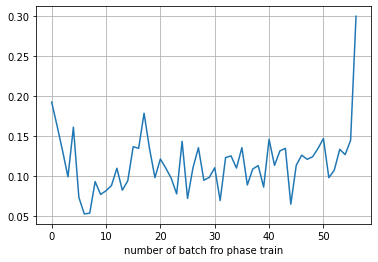

train Loss: 0.5519 acc: 0.1165 cluster_acc: 0.13450954477312546
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(8, 784)


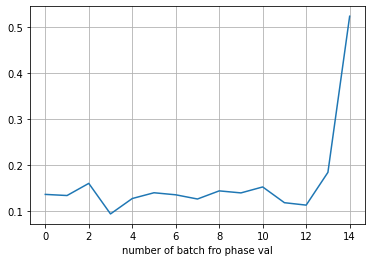

val Loss: 0.6200 acc: 0.1621 cluster_acc: 0.17858644086480951
Epoch 1/3
----------
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(32, 784)


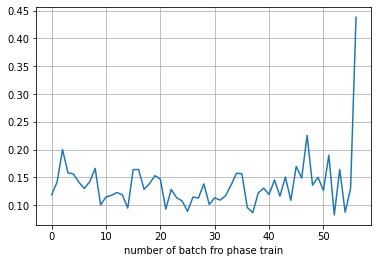

train Loss: 0.2654 acc: 0.1372 cluster_acc: 0.1438320442681067
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(8, 784)


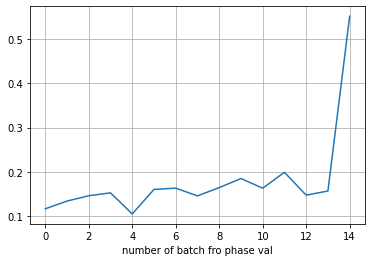

val Loss: 0.4370 acc: 0.1790 cluster_acc: 0.18888964682205822
Epoch 2/3
----------
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(32, 784)


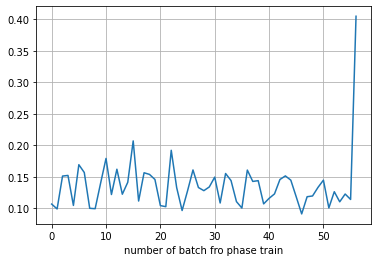

train Loss: 0.2047 acc: 0.1369 cluster_acc: 0.1398146164812277
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(8, 784)


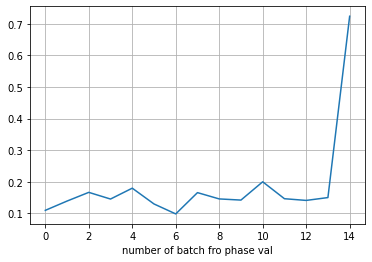

val Loss: 0.3080 acc: 0.1853 cluster_acc: 0.18174376592599312
Epoch 3/3
----------
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(32, 784)


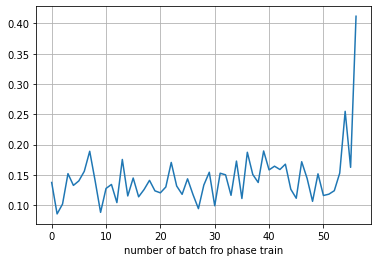

train Loss: 0.2036 acc: 0.1440 cluster_acc: 0.14428316091098836
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(128, 784)
(8, 784)


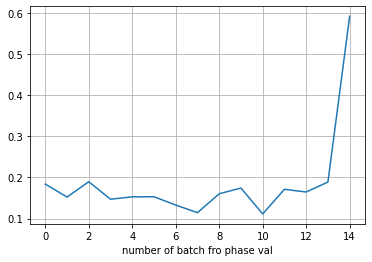

val Loss: 0.2864 acc: 0.1858 cluster_acc: 0.18436956153953515
Training complete in 27m 10s
Best : 0.286382


In [115]:
model_ft_tf = train_model(net, criterion_class, optimizer_ft, num_epochs=4)